# Figure 2. Dynamics of the voltage and synaptic variables


Copyright (C) 2023 Robert Gowers and Magnus Richardson

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public
License as published by the Free Software Foundation; either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, see <https://www.gnu.org/licenses>.

---   

In [1]:
# Packages
using PyPlot
using DelimitedFiles
using Statistics
using Distributions
using SpecialFunctions

# Load general functions and model parameters
include("CommonCode.jl");


------------------------------------------
EL=-60.0 	Ee=0.0  	Ei=-80.0
tauL=40.0 	taue=3.0 	taui=10.0
lamL=224.0 	lame=19.0 	lami=64.0
		game=0.1 	gami=0.1

kappa=0.6 tau0=24.0
D=1250.0
Vth=-50.0 Vre=-60.0
L=2000.0
------------------------------------------



---   

# (i) Theory for patterned input

In [2]:
# Fluctuations are around the same steady state values used for the later figures.
# Need to find the mean voltage corresponding to target rate rstar.

# The range of resting voltages
dEthe=0.1;
EEthe=collect(EL:dEthe:Vth)
nEEthe=length(EEthe)
aL=1/tauL; a0=aL/kappa
aae=((EEthe .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei)
aai=((Ee .-EEthe)*a0 .- aL*(Ee-EL))/(Ee-Ei);

# Theoretical quantities
DV0EEthe,Dvv0EEthe,Ddvdv0EEthe,Dru0EEthe,Dvhe0EEthe,Dvhi0EEthe=(zeros(nEEthe) for j=1:6)
for k=1:nEEthe
    DV0EEthe[k],Dvhe0EEthe[k],Dvhi0EEthe[k],Dvv0EEthe[k],Ddvdv0EEthe[k],Dru0EEthe[k]=DendrSteadyTheory(aae[k],aai[k]);
end

# Linear interpolation for the mean voltage
GetxStar(x1,x2,y1,y2,ystar)=x1 + (x2-x1)*(ystar-y1)/(y2-y1)
sD2=minimum(findall(Dru0EEthe.>rstar)); sD1=sD2-1
DEstar=GetxStar(EEthe[sD1],EEthe[sD2],Dru0EEthe[sD1],Dru0EEthe[sD2],rstar)

# Get the various upcrossing parameters for these values
Daestar=((DEstar .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei)
Daistar=((Ee .-DEstar)*a0 .- aL*(Ee-EL))/(Ee-Ei);
DV0Esthe,Dvhe0Esthe,Dvhi0Esthe,Dvv0Esthe,Ddvdv0Esthe,Dru0Esthe=DendrSteadyTheory(Daestar,Daistar);

PEstar=DEstar

print("Mean voltage for r*=$(rstarHz)Hz is E*=$(round(DEstar,digits=2))mV\n")
print("Actual rate at this mean voltage is $(round(K*Dru0Esthe,digits=3))Hz")


Mean voltage for r*=5.0Hz is E*=-57.12mV
Actual rate at this mean voltage is 4.999Hz

In [3]:
# Create the input pattern and the theoretical predictions

# For both point and dendrite cases
#dt=0.001; dx=5
#dt=0.005; dx=10;
dt=0.02; dx=20;
#dt=0.04; dx=25

T=1000; 

t=collect(dt:dt:T); nt=length(t); 
x=collect(dx:dx:L); nx=length(x);

sh=Int(L/(2dx));

###############################################################
# Construct the stimulation
###############################################################

MyChirpBump(t,a,t0,s,fHz)=a*exp.(-(t .-t0).^2/(2*s^2)).*cos.(2*pi*(fHz/1000)*t)

aL=1/tauL; a0=aL/kappa
Pae=((PEstar .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei);
Pai=((Ee .-PEstar)*a0 .- aL*(Ee-EL))/(Ee-Ei);
Dae=((DEstar .-Ei)*a0 .- aL*(EL-Ei))/(Ee-Ei);
Dai=((Ee .-DEstar)*a0 .- aL*(Ee-EL))/(Ee-Ei);

# Construct the waveforms for point and dendrite cases 
s=findall(250 .<=t .<=750)
Paet,Pait=zeros(nt),zeros(nt); Paet[s].=Pae; Pait[s].=Pai;
Daet,Dait=zeros(nt),zeros(nt); Daet[s].=Dae; Dait[s].=Dai;

Pf=0.08
Df=0.08

chirp1=(250 .<=t .<=750).*MyChirpBump(t,0.03,350,20,20);
chirp2=(250 .<=t .<=750).*MyChirpBump(t,0.03,450,20,50);
chirp3=(250 .<=t .<=750).*MyChirpBump(t,0.03,550,20,100);
chirp4=(250 .<=t .<=750).*MyChirpBump(t,0.03,650,20,200);

Paet=Paet .+ Pf*(chirp1 .+ chirp2 .+ chirp3 .+ chirp4)
Daet=Daet .+ Df*(chirp1 .+ chirp2 .+ chirp3 .+ chirp4);

###############################################################
# Get the theoretical results
###############################################################

# the theoretical upcrossing rates and various other quantities
PmUthe,PmHethe,PmHithe,PmdUdtthe,Phevthe,Phivthe,Pvvthe,Pvdvthe,Pdvdvthe,Pruthe=PointDynamicTheory(t,Paet,Pait);
DmUthe,DmHethe,DmHithe,DmdUdtthe,Dhevthe,Dhivthe,Dvvthe,Dvdvthe,Ddvdvthe,Druthe=DendrDynamicTheory(x,t,Daet,Dait);


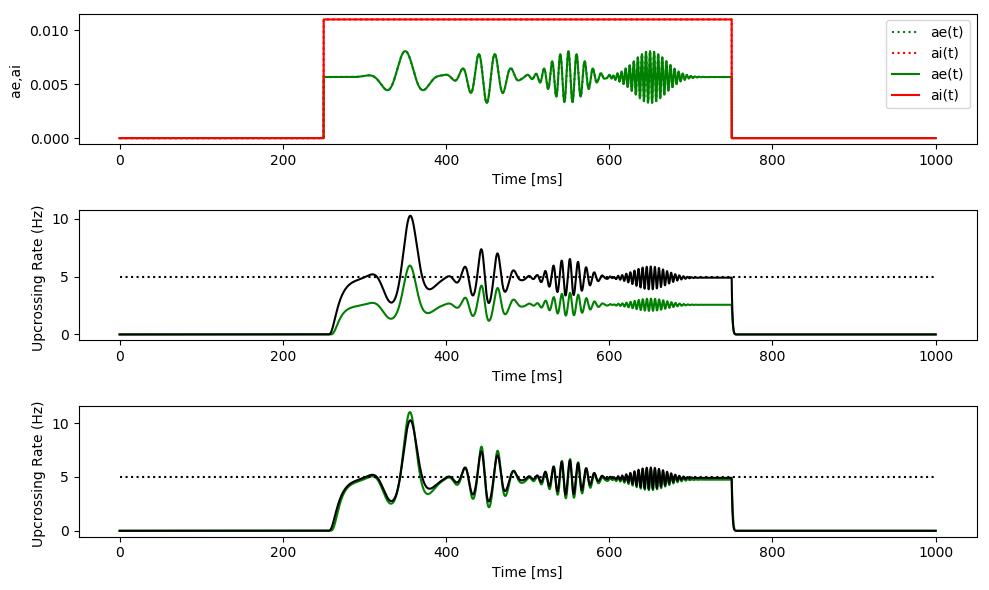

In [4]:
###############################################################
# Plot the rates
###############################################################

pygui(false)
figure(figsize=(10,6))

subplot(311)
plot(t,Paet,label="ae(t)","g:"); plot(t,Pait,label="ai(t)","r:")
plot(t,Daet,label="ae(t)","g-"); plot(t,Dait,label="ai(t)","r-")
legend(); xlabel("Time [ms]"); ylabel("ae,ai ");

subplot(312)
plot(t,K*Pruthe,"g-");plot(t,K*Druthe,"k-",[0,T],rstarHz*[1,1],"k:")
xlabel("Time [ms]"); ylabel("Upcrossing Rate (Hz) ");

subplot(313)
plot(t,1.85*K*Pruthe,"g-");plot(t,K*Druthe,"k-",[0,T],rstarHz*[1,1],"k:")
xlabel("Time [ms]"); ylabel("Upcrossing Rate (Hz) ");

tight_layout()

In [5]:
Dae,Dai

(0.005664643790016989, 0.01100202287664968)

---  

# (ii) Simulations for patterned input

In [10]:
###############################################################
# Get data...
###############################################################

#nsD=20;nsP=200;nr=2
#nsD=50;nsP=500;nr=5
#nsD=100;nsP=1000;nr=10
nsD=200;nsP=2000;nr=20 
#nsD=400;nsP=2000;nr=50

PrUtr,PrVtr,Prutr=zeros(nt,nr),zeros(nt,nr),zeros(nt,nr)
Lrutr=zeros(nt,nr)

@time Prutr[:,1],~,~,~,~=PointSweeps(t,Paet,Pait,nsP);
@time Lrutr[:,1],~,~,~,~=DendrSweeps(x,t,Daet,Dait,nsD);

print("Done: ")
for k=2:nr
    Prutr[:,k],~,~,~,~=PointSweeps(t,Paet,Pait,nsP);
    Lrutr[:,k],~,~,~,~=DendrSweeps(x,t,Daet,Dait,nsD)
    print(" $k")
end

PrUt,PrVt,Prut=mean.((PrUtr,PrVtr,Prutr),dims=2);
Lrut=mean(Lrutr,dims=2);


 44.197086 seconds (146.10 k allocations: 26.092 GiB, 14.23% gc time)
225.206010 seconds (613.07 M allocations: 378.324 GiB, 23.19% gc time)
Done:  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

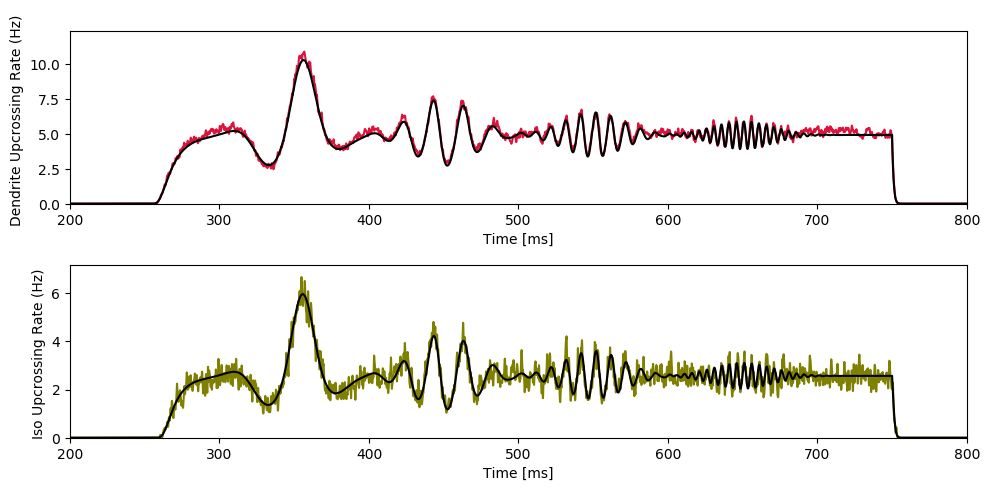

In [11]:
# Weakly smooth the simulations for display
eps=0.2; N=Int(round(1/(eps*dt);digits=0))
PrUtS,PrutS=Smooth.((PrUt,Prut),N,eps)
LrutS=Smooth(Lrut,N,eps);

pygui(false); figure(figsize=(10,5)); 

subplot(211); axis([200,800,0,1.2*maximum(K*Druthe)]);
plot(t,K*LrutS,color="crimson"); plot(t,K*Druthe,"k-"); 
xlabel("Time [ms]"); ylabel("Dendrite Upcrossing Rate (Hz) ");

subplot(212);axis([200,800,0,1.2*maximum(K*Pruthe)]);
plot(t,K*PrutS,color="olive"); plot(t,K*Pruthe,"-k"); 
xlabel("Time [ms]"); ylabel("Iso Upcrossing Rate (Hz) ");

tight_layout()

---

# (iii) Figure 2 code

In [13]:
##################################################################
# Figure 2.
##################################################################

pygui(true)
fig=figure(figsize=1.6.*(3.375,3.125))

panelfs=14
labelfs=8
tickfs=8
lw=1.0
ms=3

##################################################################
# Positions
##################################################################
bx,tx=0.1,0.95 # top and bottom x edges
by,ty=0.1,0.95 # top and bottom y edges

wx=(tx-bx)

gAB=0.1
gB=0.02
gBC=0.06
hA=0.08
hC=0.15
hB=(ty-by-hC-gBC-4gB-gAB-hA)/5
hB<0 ? println("hB negative") : ()

xA,yA,wA=bx,ty-hA,wx
xB1,yB1,wB=bx,by+hC+gBC+4*(hB+gB),wx
xB2,yB2,wB=bx,by+hC+gBC+3*(hB+gB),wx
xB3,yB3,wB=bx,by+hC+gBC+2*(hB+gB),wx
xB4,yB4,wB=bx,by+hC+gBC+1*(hB+gB),wx
xB5,yB5,wB=bx,by+hC+gBC+0*(hB+gB),wx
xC,yC,wC=bx,by,wx

t1=70
t2=640

##############################################################
# Panel 2A. 
##############################################################

fig.text(0.015, 0.95, "A", fontsize=panelfs)
ax7=plt.axes([xA,yA,wA,hA]); 
xlabel("Time (ms)",fontsize=labelfs); 
ylabel(L"$\alpha_\mathrm{e}$, $\alpha_\mathrm{i}$",fontsize=labelfs)
plot(t .-150,Daet,label="ae(t)","g-",linewidth=lw)
plot(t .-150,Dait,label="ai(t)","r-",linewidth=lw)
axis([t1,t2,0,1.1*maximum(Dait)])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)
text(85,0.01,"i",fontsize=tickfs)
text(82,0.005,"e",fontsize=tickfs)

##############################################################
# Panel 2B. Deterministic and fluctuation responses
##############################################################

fig.text(0.015, 0.775, "B", fontsize=panelfs)

ax6=plt.axes([xB1,yB1,wB,hB]); 
ylabel(L"$\langle V \rangle$",fontsize=labelfs)
plot(t .-150,DmUthe,linewidth=lw,"k-")
axis([t1,t2,minimum(DmUthe)*1.01,maximum(DmUthe)+0.1])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)
ax6.set_yticks([-60,-57])
ax6.set_yticklabels(["-60","-57"],fontsize=tickfs)

ax5=plt.axes([xB2,yB2,wB,hB]); 
ylabel(L"$\langle \dot{V} \rangle$",fontsize=labelfs)
plot(t.-150,DmdUdtthe,linewidth=lw,"k-")
axis([t1,t2,minimum(DmdUdtthe)*1.01,maximum(DmdUdtthe)*1.01])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)
ax5.set_yticks([-0.1,0.1])
ax5.set_yticklabels(["-0.1","0.1"],fontsize=tickfs)

ax4=plt.axes([xB3,yB3,wB,hB]); 
ylabel(L"$\langle v^2 \rangle$",fontsize=labelfs)
plot(t.-150,Dvvthe[1,:],linewidth=lw,"k-")
axis([t1,t2,-0.2,maximum(Dvvthe)*1.02])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)

ax3=plt.axes([xB4,yB4,wB,hB]); 
ylabel(L"$\langle v\dot{v}\rangle$",fontsize=labelfs)
plot(t.-150,Dvdvthe[1,:],linewidth=lw,"k-")
axis([t1,t2,minimum(Dvdvthe)*1.02,maximum(Dvdvthe)*1.02])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)
ax3.set_yticks([-0.3,0,0.3])
ax3.set_yticklabels(["-0.3","0","0.3"],fontsize=tickfs)

ax2=plt.axes([xB5,yB5,wB,hB]); 
ylabel(L"$\langle \dot{v}^2 \rangle$",fontsize=labelfs)
plot(t.-150,Ddvdvthe[1,:],linewidth=lw,"k-")
axis([t1,t2,-0.01,maximum(Ddvdvthe)*1.02])
xticks(fontsize=tickfs);yticks(fontsize=tickfs)

##############################################################
# Panel 2C. Upcrossing rate
##############################################################

fig.text(0.015, 0.26, "C", fontsize=panelfs)
ax1=plt.axes([xC,yC,wC,hC]); 
xlabel("Time (ms)",fontsize=labelfs); 
ylabel("Rate (Hz)",fontsize=labelfs)
xticks(fontsize=tickfs);yticks(fontsize=tickfs)
plot(t.-150,K*LrutS,color="darkgray",linewidth=lw)
plot(t.-150,K*Druthe,"k-",linewidth=lw);
axis([t1,t2,0,11])

##############################################################
# tidy up
##############################################################

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.yaxis.set_tick_params(rotation=90)
end

for ax in (ax2,ax3,ax4,ax5,ax6)
     ax.spines["bottom"].set_visible(false)
     ax.get_xaxis().set_visible(false)
    ax.yaxis.set_tick_params(rotation=0)
    #ax.tick_params(axis="both", which="major", labelsize=8)
end

#ax5.yaxis.set_tick_params(rotation=90)

 savefig("Fig2.pdf")